# PHYSBO の基本

## はじめに


本チュートリアルでは例として、一次元の関数の最小値を求める例題を解きます。
はじめに、PHYSBOをインポートします。

In [1]:
import physbo

## 探索候補データの準備

最初に関数を探索する空間を定義します。
以下の例では、探索空間``X``を ``x_min = -2.0``から``x_max = 2.0``まで``window_num=10001``分割で刻んだグリッドで定義しています。
なお、``X``は ``window_num`` x ``d`` のndarray形式にする必要があります(``d``は次元数、この場合は1次元)。そのため、reshapeを行って変形しています。

In [2]:
#In
import numpy as np
import scipy
import physbo
import itertools

#In
#Create candidate
window_num=10001
x_max = 2.0
x_min = -2.0

X = np.linspace(x_min,x_max,window_num).reshape(window_num, 1)

## simulatorクラスの定義

目的関数を定義するためのsimulatorクラスをここで定義します。

今回はf(x) = 3 x^4 + 4 x ^3 + 1.0 が最小となるxを探索するという問題設定にしています(答えはx=-1.0)。

simulatorクラスでは、``__call__``関数を定義します(初期変数などがある場合は``__init__``を定義します)。
actionは探索空間の中から取り出すグリッドのindex番号を示しており、複数の候補を一度に計算できるように一般的にndarrayの形式を取っています。
今回は一つの候補のみを毎回計算するため、``action_idx=action[0]``として``X``から候補点を一つ選んでいます。
**PHYSBOでは目的関数値が最大となる**ものを求める仕様になっているため、候補点でのf(x)の値に-1をかけたものを返しています。

In [3]:
# Declare the class for calling the simulator.
class simulator:

    def __call__(self, action):
        action_idx = action[0]
        x = X[action_idx][0]
        fx = 3.0*x**4 + 4.0*x**3 + 1.0
        fx_list.append(fx)
        x_list.append(X[action_idx][0])

        print ("*********************")
        print ("Present optimum interactions")

        print ("x_opt=", x_list[np.argmin(np.array(fx_list))])

        return -fx

## 最適化の実行

### policy のセット

まず、最適化の `policy` をセットします。  

`test_X` に探索候補の行列 (`numpy.array`) を指定します。

In [4]:
# policy のセット 
policy = physbo.search.discrete.policy(test_X=X)

# シード値のセット 
policy.set_seed(0)

`policy` をセットした段階では、まだ最適化は行われません。
`policy` に対して以下のメソッドを実行することで、最適化を行います。

- `random_search`  
- `bayes_search`

これらのメソッドに先ほど定義した `simulator` と探索ステップ数を指定すると、探索ステップ数だけ以下のループが回ります。

i) パラメータ候補の中から次に実行するパラメータを選択

ii) 選択されたパラメータで `simulator` を実行

i) で返されるパラメータはデフォルトでは1つですが、1ステップで複数のパラメータを返すことも可能です。
詳しくは「複数候補を一度に探索する」の項目を参照してください。  

また、上記のループを PHYSBO の中で回すのではなく、i) と ii) を別個に外部から制御することも可能です。つまり、PHYSBO から次に実行するパラメータを提案し、その目的関数値をPHYBOの外部で何らかの形で評価し（例えば、数値計算ではなく、実験による評価など）、それをPHYSBOの外部で何らかの形で提案し、評価値をPHYSBOに登録する、という手順が可能です。詳しくは、チュートリアルの「インタラクティブに実行する」の項目を参照してください。

### ランダムサーチ

まず初めに、ランダムサーチを行ってみましょう。

ベイズ最適化の実行には、目的関数値が2つ以上求まっている必要があるため（初期に必要なデータ数は、最適化したい問題、パラメータの次元dに依存して変わります）、まずランダムサーチを実行します。   

**引数**  

- `max_num_probes`: 探索ステップ数  
- `simulator`: 目的関数のシミュレータ (simulator クラスのオブジェクト) 

In [ ]:
fx_list=[]
x_list = []
res = policy.random_search(max_num_probes=20, simulator=simulator())

実行すると、各ステップの目的関数値とその action ID、現在までのベスト値とその action ID に関する情報が以下のように出力されます。

```
0020-th step: f(x) = -19.075990 (action=8288)
   current best f(x) = -0.150313 (best action=2949) 
```


### ベイズ最適化

続いて、ベイズ最適化を以下のように実行します。

**引数**  

- `max_num_probes`: 探索ステップ数  
- `simulator`: 目的関数のシミュレータ (simulator クラスのオブジェクト)  
- `score`: 獲得関数(acquisition function) のタイプ。以下のいずれかを指定します。
    - TS (Thompson Sampling)  
    - EI (Expected Improvement)  
    - PI (Probability of Improvement)  
- `interval`:  
指定したインターバルごとに、ハイパーパラメータを学習します。  
負の値を指定すると、ハイパーパラメータの学習は行われません。  
0 を指定すると、ハイパーパラメータの学習は最初のステップでのみ行われます。  
- `num_rand_basis`: 基底関数の数。0を指定すると、Bayesian linear modelを利用しない通常のガウス過程が使用されます。  

In [ ]:
res = policy.bayes_search(max_num_probes=50, simulator=simulator(), score='TS', 
                                                  interval=0, num_rand_basis=500)

## 結果の確認

探索結果 res は history クラスのオブジェクト (`physbo.search.discrete.results.history`) として返されます。  
以下より探索結果を参照します。

- `res.fx` : simulator (目的関数) の評価値の履歴。
- `res.chosen_actions`: simulator を評価したときの action ID (パラメータ) の履歴。  
- `fbest, best_action= res.export_all_sequence_best_fx()`: simulator を評価した全タイミングにおけるベスト値とその action ID (パラメータ)の履歴。
- `res.total_num_search`: simulator のトータル評価数。

各ステップでの目的関数値と、ベスト値の推移をプロットしてみましょう。  
`res.fx`, `best_fx` はそれぞれ `res.total_num_search` までの範囲を指定します。

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

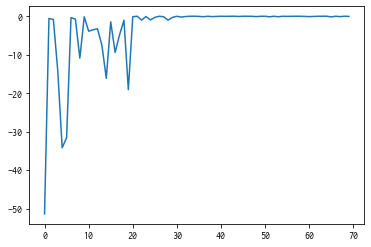

In [8]:
plt.plot(res.fx[0:res.total_num_search])

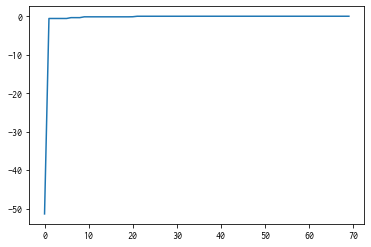

In [9]:
best_fx, best_action = res.export_all_sequence_best_fx()
plt.plot(best_fx)

## 結果のシリアライズ

探索結果は `save` メソッドにより外部ファイルに保存できます。

In [10]:
res.save('search_result.npz')

In [11]:
del res

保存した結果ファイルは以下のようにロードすることができます。

In [12]:
res = physbo.search.discrete.results.history()
res.load('search_result.npz')

最後に、一番よいスコアを持つ候補は以下のようにして表示することができます。正しい解 x=-1に行き着いていることがわかります。

In [13]:
print(X[int(best_action[-1])])

[-1.002]


## 獲得関数

`get_score` メソッドで獲得関数を計算可能です。

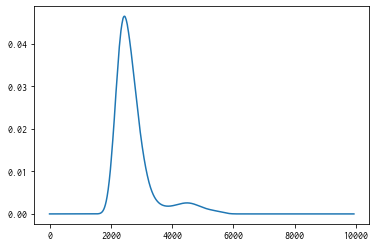

In [17]:
score = policy.get_score(mode="EI")
plt.plot(score)

## 並列化

PHYSBO は全候補点に対する獲得関数の計算をMPI を用いて並列化出来ます。
MPI 並列には `mpi4py` を用います。

並列化を有効化するには、 `policy` のコンストラクタのキーワード引数 `comm` に MPI コミュニケータ、たとえば `MPI.COMM_WORLD` を渡してください。

In [15]:
# from mpi4py import MPI
# policy = physbo.search.discrete.policy(X=test_X, comm=MPI.COMM_WORLD)